**Hand-in Group: g16**

*Students:* <br>
anderdav@students.zhaw.ch <br>
goodnic1@students.zhaw.ch <br>
janick.rueegger@students.fhnw.ch <br>
neyerjoh@students.zhaw.ch <br>

In [2]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

*for debugging:*

In [3]:
from pprint import pprint

def pp(obj):
    pprint(vars(obj))

### Loading Data

In [4]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [5]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [6]:
print("n training: ", len(training_data))
print("n validation: ", len(validation_data))
print("n test: ", len(test_data))

n training:  50000
n validation:  10000
n test:  10000


### MLP


In [7]:
def mlp(units = [28*28,250,80,10]):
    seq = [torch.nn.Flatten()]
    for i in range(len(units)-2):
        seq.append(torch.nn.Linear(units[i],units[i+1]))
        seq.append(torch.nn.Sigmoid())
    seq.append(torch.nn.Linear(units[-2],units[-1]))
    return torch.nn.Sequential(*seq)

In [8]:
model = mlp()
summary(model, (1,28,28))

Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Linear: 1-2                            [-1, 250]                 196,250
├─Sigmoid: 1-3                           [-1, 250]                 --
├─Linear: 1-4                            [-1, 80]                  20,080
├─Sigmoid: 1-5                           [-1, 80]                  --
├─Linear: 1-6                            [-1, 10]                  810
Total params: 217,140
Trainable params: 217,140
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.83
Estimated Total Size (MB): 0.83


Layer (type:depth-idx)                   Output Shape              Param #
├─Flatten: 1-1                           [-1, 784]                 --
├─Linear: 1-2                            [-1, 250]                 196,250
├─Sigmoid: 1-3                           [-1, 250]                 --
├─Linear: 1-4                            [-1, 80]                  20,080
├─Sigmoid: 1-5                           [-1, 80]                  --
├─Linear: 1-6                            [-1, 10]                  810
Total params: 217,140
Trainable params: 217,140
Non-trainable params: 0
Total mult-adds (M): 0.22
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.83
Estimated Total Size (MB): 0.83

### Training

Implement the training / evaluation loop

Remember training / validation cost and accuracy per epoch. 

In [9]:
def train_eval(model, optimizer, nepochs, training_loader, test_loader, scheduler=None):
    cost_hist = []
    cost_hist_test = []
    acc_hist = []
    acc_hist_test = []

    cost_ce = torch.nn.CrossEntropyLoss()
    
    print("Epoch \t\t Train Costs \t Train Accuracy \t Test Costs \t Test Accuracy")
    for epoch in range(nepochs):
        model.train()
        size = len(training_loader.dataset)
        nbatches = len(training_loader)
        size_test = len(test_loader.dataset)
        nbatches_test = len(test_loader)
        cost, acc = 0.0, 0.0
        for batch, (X, Y) in enumerate(training_loader):
            pred = model(X)
            loss = cost_ce(pred, Y)
            cost += loss.item()
            acc += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()

            # gradient, parameter update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        if scheduler:
            scheduler.step()
        cost /= nbatches
        acc /= size
    
        model.eval()
        cost_test, acc_test = 0.0, 0.0        
        with torch.no_grad():
            for X, Y in test_loader:
                pred = model(X)
                cost_test += cost_ce(pred, Y).item()
                acc_test += (pred.argmax(dim=1) == Y).type(torch.float).sum().item()
        cost_test /= nbatches_test
        acc_test /= size_test
        print("%i \t\t %f \t %f \t\t %f \t %f"%(epoch, cost, acc, cost_test, acc_test))
        cost_hist.append(cost)
        cost_hist_test.append(cost_test)
        acc_hist.append(acc)
        acc_hist_test.append(acc_test)
    return cost_hist, cost_hist_test, acc_hist, acc_hist_test

### Analyse Different Optimisers with different Settings 

Use the code above to explore different settings for the different optimizers. Use batchsize 64.

1. SGD: Revisit plain SGD (without momentum) and try different learning rates (lr). Create suitable comparison plots (learning curves with the train and validate cost and accuracy) for (~3) different learning rates. Describe in words what you see. What is a reasonable number of epochs (nepochs)? What is your recommended best choice (lr, nepochs) for the given problem?

2. Momentum: Play with different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?

3. RMSprop: Same thing now for RMSprop (without momentum). Play with different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?

4. Adam: Same thing now for Adam. Play with different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?

5. Learning rate schedule: Implement a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task? Note the way how the scheduler is incorporated into the `train_eval`-method above.


In [10]:
def experiment(model, optimizer, nepochs, scheduler=None):
    nbatch = 64

    training_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    validation_loader = DataLoader(validation_data, batch_size=nbatch, shuffle=True)
    
    if scheduler:
        cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, validation_loader, scheduler=scheduler)
    else:
        cost_hist, cost_hist_test, acc_hist, acc_hist_test = train_eval(model, optimizer, nepochs, training_loader, validation_loader)
    
    rnepochs = list(range(1, nepochs+1))
    
    plt.figure(1)
    plt.title(f"Costs - Optimizer: {type(optimizer).__name__}, Learning-Rate: {optimizer.param_groups[0]['lr']}, Epochs: {nepochs}")
    plt.ylabel('Cost')
    plt.xlabel('Epoch')
    plt.plot(torch.arange(nepochs), cost_hist, '-', label='training')
    plt.plot(torch.arange(nepochs), cost_hist_test, 'r-', label='test')
    plt.legend()
    
    plt.figure(2)
    plt.title(f"Accuracy - Optimizer: {type(optimizer).__name__}, Learning-Rate: {optimizer.param_groups[0]['lr']}, Epochs: {nepochs}")
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.plot(torch.arange(nepochs), acc_hist, '-', label='training')
    plt.plot(torch.arange(nepochs), acc_hist_test, 'r-', label='test')
    plt.legend()
    
    plt.show()


### Plots and Comments (for the different steps described above) 

#### 1. SGD

*Exercise* \
Revisit plain SGD (without momentum) and try different learning rates (lr). Create suitable comparison plots (learning curves with the train and validate cost and accuracy) for (~3) different learning rates. Describe in words what you see. What is a reasonable number of epochs (nepochs)? What is your recommended best choice (lr, nepochs) for the given problem?


*Link:* https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

*Epochs*

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.730073 	 0.375800 		 1.117344 	 0.598800
1 		 0.913384 	 0.657360 		 0.802104 	 0.687100
2 		 0.704991 	 0.739480 		 0.673116 	 0.759100
3 		 0.610160 	 0.772560 		 0.604740 	 0.763200
4 		 0.558380 	 0.794000 		 0.548459 	 0.808600
5 		 0.522132 	 0.811480 		 0.592024 	 0.779500
6 		 0.496027 	 0.822120 		 0.565575 	 0.790500
7 		 0.476956 	 0.829480 		 0.516083 	 0.814200
8 		 0.460427 	 0.835520 		 0.491993 	 0.825200
9 		 0.447244 	 0.838960 		 0.491782 	 0.821700


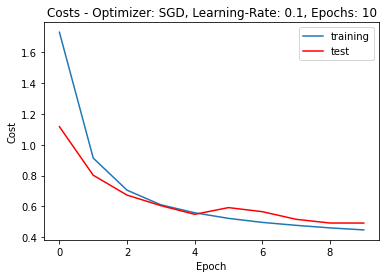

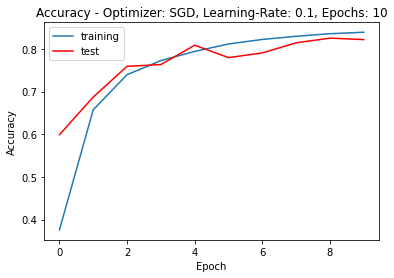

In [11]:
model = mlp()

nepochs = 10

lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

experiment(model, optimizer, nepochs)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.764554 	 0.365100 		 1.123613 	 0.594900
1 		 0.922277 	 0.655540 		 0.792431 	 0.702300
2 		 0.706594 	 0.738540 		 0.673464 	 0.749400
3 		 0.608726 	 0.772200 		 0.599195 	 0.785600
4 		 0.552372 	 0.799280 		 0.555793 	 0.799400
5 		 0.516148 	 0.814600 		 0.513717 	 0.824300
6 		 0.488417 	 0.825480 		 0.487871 	 0.827700
7 		 0.468744 	 0.832760 		 0.526767 	 0.811000
8 		 0.453851 	 0.837460 		 0.488840 	 0.830800
9 		 0.441159 	 0.842380 		 0.473179 	 0.831200
10 		 0.431299 	 0.845900 		 0.449953 	 0.837500
11 		 0.420541 	 0.848460 		 0.471857 	 0.832600
12 		 0.412721 	 0.852200 		 0.470521 	 0.832700
13 		 0.404561 	 0.854640 		 0.419310 	 0.851200
14 		 0.397806 	 0.857460 		 0.413048 	 0.853900
15 		 0.390201 	 0.860100 		 0.449021 	 0.836500
16 		 0.387236 	 0.860220 		 0.443483 	 0.842000
17 		 0.381307 	 0.863660 		 0.429833 	 0.844400
18 		 0.375145 	 0.864420 		 0.421222 	 0.850500
19 		 0.3710

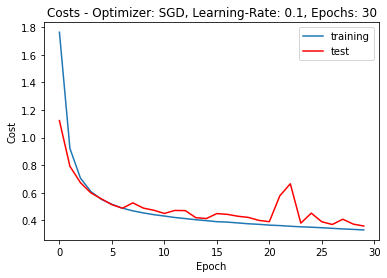

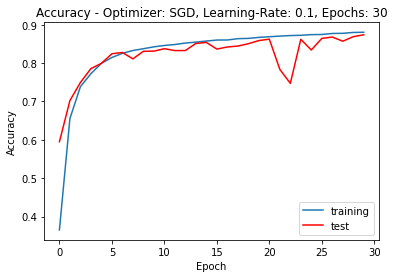

In [12]:
model = mlp()

nepochs = 30

lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

experiment(model, optimizer, nepochs)

*Learning Rates*

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.760407 	 0.367020 		 1.096917 	 0.620800
1 		 0.921376 	 0.657820 		 0.788165 	 0.697000
2 		 0.703539 	 0.740520 		 0.634235 	 0.763400
3 		 0.608639 	 0.773900 		 0.583028 	 0.789900
4 		 0.557303 	 0.797520 		 0.532764 	 0.802600
5 		 0.524953 	 0.811880 		 0.586513 	 0.780600
6 		 0.498137 	 0.822820 		 0.484167 	 0.827600
7 		 0.479298 	 0.829240 		 0.479702 	 0.830100
8 		 0.462394 	 0.835100 		 0.465093 	 0.834500
9 		 0.449108 	 0.837780 		 0.437446 	 0.845700
10 		 0.436697 	 0.842600 		 0.446557 	 0.839800
11 		 0.425989 	 0.847720 		 0.428506 	 0.848900
12 		 0.418141 	 0.849840 		 0.510529 	 0.808000
13 		 0.409963 	 0.853740 		 0.438848 	 0.845400
14 		 0.402210 	 0.856120 		 0.447664 	 0.838100
15 		 0.396088 	 0.857240 		 0.425668 	 0.849000
16 		 0.390492 	 0.858980 		 0.399748 	 0.859700
17 		 0.384784 	 0.861900 		 0.412091 	 0.849200
18 		 0.379211 	 0.864160 		 0.427071 	 0.841800
19 		 0.3738

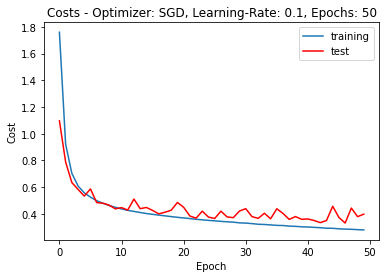

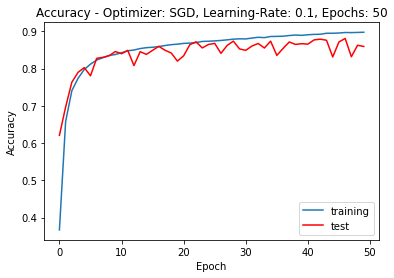

In [85]:
model = mlp()

nepochs = 50

lr = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

experiment(model, optimizer, nepochs)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.157519 	 0.558980 		 1.085580 	 0.526700
1 		 0.600006 	 0.776440 		 0.752760 	 0.716600
2 		 0.516217 	 0.811660 		 0.580733 	 0.778200
3 		 0.472235 	 0.827840 		 0.538700 	 0.797500
4 		 0.440797 	 0.840480 		 0.580856 	 0.792500
5 		 0.421655 	 0.847400 		 0.463250 	 0.831800
6 		 0.402406 	 0.854000 		 0.505002 	 0.819200
7 		 0.388760 	 0.857360 		 0.396205 	 0.858300
8 		 0.374787 	 0.863000 		 0.392702 	 0.860500
9 		 0.364115 	 0.866780 		 0.430761 	 0.845700
10 		 0.353770 	 0.870220 		 0.371826 	 0.863100
11 		 0.345837 	 0.873420 		 0.422385 	 0.845700
12 		 0.335834 	 0.876480 		 0.368133 	 0.873600
13 		 0.326718 	 0.881800 		 0.352084 	 0.873900
14 		 0.321372 	 0.881120 		 0.416714 	 0.848400
15 		 0.314960 	 0.885120 		 0.434962 	 0.840600
16 		 0.309563 	 0.887380 		 0.336058 	 0.880600
17 		 0.301909 	 0.889660 		 0.340175 	 0.880200
18 		 0.298401 	 0.891740 		 0.346880 	 0.872800
19 		 0.2921

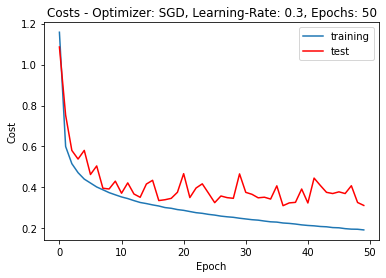

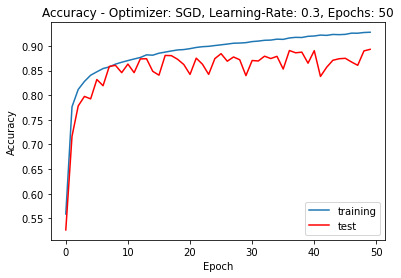

In [84]:
model = mlp()

nepochs = 50

lr = 0.3
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

experiment(model, optimizer, nepochs)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 0.992323 	 0.616380 		 0.790069 	 0.697300
1 		 0.550990 	 0.794620 		 0.485205 	 0.830300
2 		 0.475980 	 0.826380 		 0.459894 	 0.831700
3 		 0.435419 	 0.840420 		 0.611773 	 0.775900
4 		 0.408876 	 0.850000 		 0.467009 	 0.833800
5 		 0.388069 	 0.856900 		 0.420103 	 0.853500
6 		 0.371275 	 0.862720 		 0.484283 	 0.831500
7 		 0.359741 	 0.869040 		 0.407610 	 0.851300
8 		 0.346764 	 0.871660 		 0.381742 	 0.860600
9 		 0.334960 	 0.876780 		 0.381971 	 0.863300
10 		 0.325473 	 0.878720 		 0.440866 	 0.842600
11 		 0.317588 	 0.882620 		 0.390055 	 0.855600
12 		 0.308578 	 0.886200 		 0.427851 	 0.829300
13 		 0.299674 	 0.888420 		 0.411650 	 0.859100
14 		 0.294613 	 0.890880 		 0.342447 	 0.877600
15 		 0.289654 	 0.893220 		 0.414959 	 0.836400
16 		 0.281886 	 0.895240 		 0.347718 	 0.875300
17 		 0.277112 	 0.896760 		 0.393702 	 0.855400
18 		 0.270826 	 0.899440 		 0.351973 	 0.876800
19 		 0.2665

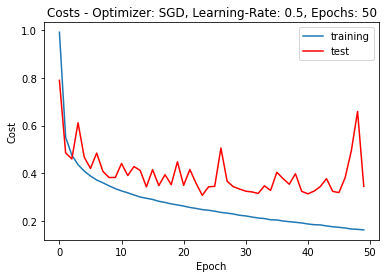

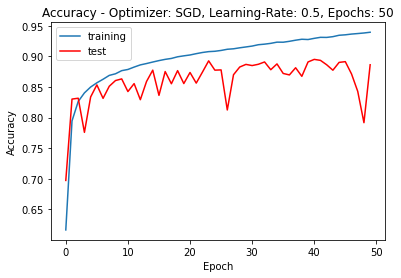

In [87]:
model = mlp()

nepochs = 50

lr = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

experiment(model, optimizer, nepochs)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 0.870388 	 0.661620 		 1.060117 	 0.627300
1 		 0.503091 	 0.814880 		 0.591240 	 0.774900
2 		 0.436062 	 0.839420 		 0.443622 	 0.841700
3 		 0.396216 	 0.852640 		 0.409670 	 0.848900
4 		 0.372332 	 0.861840 		 0.392471 	 0.860500
5 		 0.351569 	 0.869640 		 0.374003 	 0.860600
6 		 0.335848 	 0.876140 		 0.434037 	 0.830200
7 		 0.323879 	 0.878920 		 0.360499 	 0.865800
8 		 0.311997 	 0.885280 		 0.407061 	 0.849700
9 		 0.302156 	 0.887380 		 0.443164 	 0.836800
10 		 0.292664 	 0.891080 		 0.357949 	 0.868800
11 		 0.281942 	 0.893400 		 0.449386 	 0.828800
12 		 0.273405 	 0.898280 		 0.399224 	 0.864500
13 		 0.267447 	 0.899980 		 0.314652 	 0.886800
14 		 0.261694 	 0.902580 		 0.534664 	 0.835700
15 		 0.255938 	 0.903120 		 0.378519 	 0.858700
16 		 0.248666 	 0.906900 		 0.346304 	 0.875400
17 		 0.241247 	 0.909700 		 0.356399 	 0.874800
18 		 0.235263 	 0.911160 		 0.400757 	 0.871400
19 		 0.2299

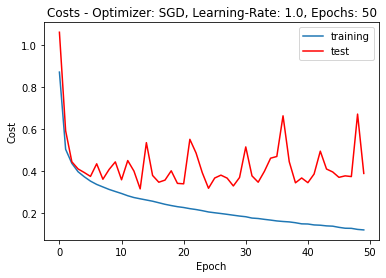

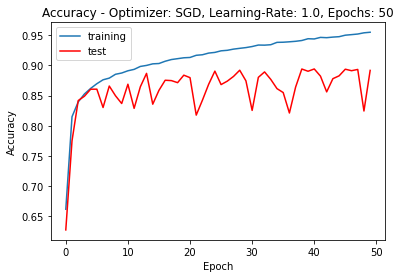

In [88]:
model = mlp()

nepochs = 50

lr = 1.
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

experiment(model, optimizer, nepochs)

*Results* \
According to our results summarized in the table below, we can conclude the following takeaways: <br>

The best combination for the `SGD` optimizer is a number of epochs of `50`, with a learning rate of `0.3`. This results in a test accuracy of `0.893000`. However, the best train accuracy of `0.954960` is achieved with a number of epochs of `50`, with a learning rate of `1.0`.


| Epochs | Learning Rate | Train Costs | Train Accuracy | Test Costs | Test Accuracy |
|-------:|---------------|-------------|----------------|------------|---------------|
| 10     | 0.1           | 0.447244    | 0.838960       | 0.491782   | 0.821700      |
| 30     | 0.1           | 0.330577    | 0.880420       | 0.358879   | 0.873800      |
| 50     | 0.1           | 0.279524    | 0.897520       | 0.397671   | 0.859400      |
| 50     | 0.3           | 0.192852    | 0.927660       | 0.312325   | 0.893000      |
| 50     | 0.5           | 0.161567    | 0.939580       | 0.344658   | 0.886400      |
| 50     | 1.0           | 0.119334    | 0.954960       | 0.388174   | 0.891700      |

#### 2. Momentum

*Exercise* \
Play with different settings when using momentum: learning rate, momentum parameter, Nesterov flag. Start with momentum=0.9 without Nesterov and suitable learning rate, then vary the momentum parameter and independently the learning rate. Can you see an impact of using Nesterov? What is your recommended best choice (lr, momentum, nesterov, nepochs) for the given problem?


*Link:*  https://pytorch.org/docs/stable/generated/torch.optim.SGD.html

*Only Momentum*

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 0.849602 	 0.672740 		 0.495253 	 0.822700
1 		 0.474332 	 0.828380 		 0.467251 	 0.824700
2 		 0.413989 	 0.849780 		 0.405615 	 0.852900
3 		 0.383711 	 0.858460 		 0.371506 	 0.866900
4 		 0.353207 	 0.870240 		 0.373707 	 0.861700
5 		 0.339450 	 0.873840 		 0.386229 	 0.863000
6 		 0.324699 	 0.878420 		 0.357940 	 0.873500
7 		 0.311551 	 0.885420 		 0.341254 	 0.878700
8 		 0.299748 	 0.889500 		 0.336175 	 0.879700
9 		 0.291091 	 0.890980 		 0.324512 	 0.884900
10 		 0.284535 	 0.895140 		 0.336754 	 0.874800
11 		 0.277854 	 0.895880 		 0.375377 	 0.859700
12 		 0.267087 	 0.900220 		 0.325804 	 0.881500
13 		 0.260818 	 0.901380 		 0.335116 	 0.882400
14 		 0.253915 	 0.904720 		 0.332535 	 0.883200
15 		 0.245251 	 0.907440 		 0.321989 	 0.883000
16 		 0.239117 	 0.909960 		 0.320271 	 0.885400
17 		 0.232018 	 0.912800 		 0.320724 	 0.886400
18 		 0.231220 	 0.913480 		 0.309898 	 0.891100
19 		 0.2238

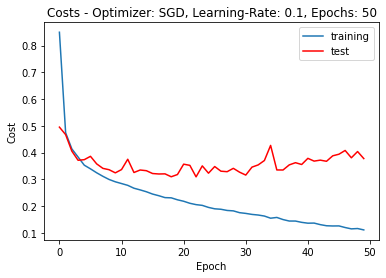

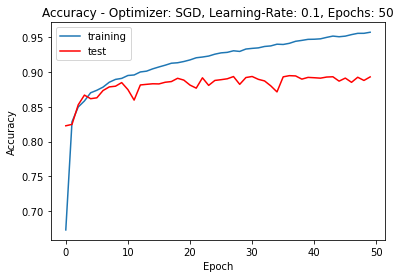

In [90]:
model = mlp()

nepochs = 50

lr = 0.1
mom = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mom)

experiment(model, optimizer, nepochs)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 0.726339 	 0.725720 		 0.457473 	 0.838400
1 		 0.437004 	 0.839320 		 0.447391 	 0.847100
2 		 0.390031 	 0.855020 		 0.392814 	 0.856900
3 		 0.361571 	 0.865700 		 0.351115 	 0.876400
4 		 0.339765 	 0.873520 		 0.367218 	 0.869500
5 		 0.325043 	 0.878180 		 0.350001 	 0.874000
6 		 0.314224 	 0.882520 		 0.387245 	 0.860600
7 		 0.304955 	 0.884540 		 0.389845 	 0.861200
8 		 0.298294 	 0.887820 		 0.341016 	 0.876100
9 		 0.286853 	 0.891980 		 0.342442 	 0.877900
10 		 0.288401 	 0.890400 		 0.339219 	 0.881200
11 		 0.277845 	 0.895400 		 0.338601 	 0.883100
12 		 0.268592 	 0.897720 		 0.335122 	 0.881400
13 		 0.267995 	 0.897560 		 0.335784 	 0.881700
14 		 0.266115 	 0.899120 		 0.366614 	 0.873800
15 		 0.257099 	 0.902340 		 0.339171 	 0.886000
16 		 0.255897 	 0.902900 		 0.342801 	 0.881500
17 		 0.252781 	 0.903500 		 0.330025 	 0.882700
18 		 0.247289 	 0.904820 		 0.339247 	 0.882100
19 		 0.2462

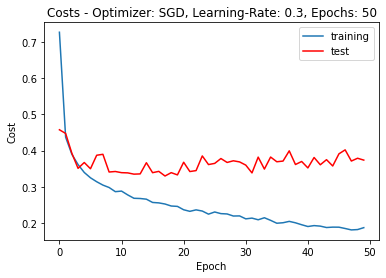

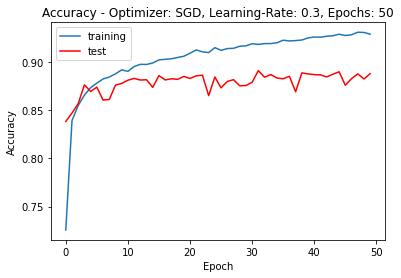

In [89]:
model = mlp()

nepochs = 50

lr = 0.3
mom = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mom)

experiment(model, optimizer, nepochs)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.333454 	 0.499540 		 0.808472 	 0.672400
1 		 0.672534 	 0.746960 		 0.583441 	 0.777100
2 		 0.554118 	 0.799040 		 0.541811 	 0.792200
3 		 0.500336 	 0.821160 		 0.505460 	 0.819700
4 		 0.466180 	 0.831540 		 0.465150 	 0.829600
5 		 0.442366 	 0.841900 		 0.438588 	 0.846900
6 		 0.425516 	 0.847100 		 0.429653 	 0.850500
7 		 0.409364 	 0.853700 		 0.413766 	 0.848600
8 		 0.398948 	 0.855900 		 0.447243 	 0.840600
9 		 0.387209 	 0.860760 		 0.386284 	 0.863500
10 		 0.376901 	 0.865040 		 0.427368 	 0.852600
11 		 0.368287 	 0.867420 		 0.406577 	 0.851500
12 		 0.362198 	 0.869240 		 0.403522 	 0.851100
13 		 0.353864 	 0.872900 		 0.370607 	 0.865800
14 		 0.348219 	 0.873860 		 0.410170 	 0.851800
15 		 0.341050 	 0.876280 		 0.386622 	 0.866300
16 		 0.334070 	 0.879620 		 0.375834 	 0.866200
17 		 0.328193 	 0.880080 		 0.361683 	 0.873800
18 		 0.324648 	 0.881060 		 0.375975 	 0.861100
19 		 0.3184

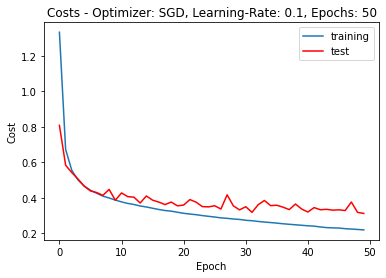

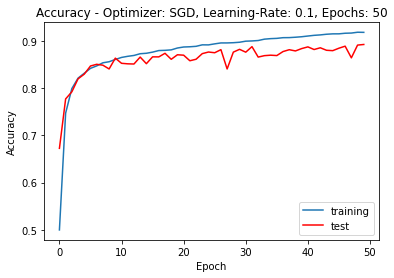

In [92]:
model = mlp()

nepochs = 50

lr = 0.1
mom = 0.5
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mom)

experiment(model, optimizer, nepochs)

*With Nesterov*

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 0.787016 	 0.704740 		 0.504695 	 0.821200
1 		 0.449652 	 0.837020 		 0.421523 	 0.855000
2 		 0.401590 	 0.853460 		 0.383610 	 0.857400
3 		 0.367294 	 0.865920 		 0.378633 	 0.864700
4 		 0.347193 	 0.874120 		 0.394913 	 0.859000
5 		 0.327765 	 0.880080 		 0.344728 	 0.873400
6 		 0.313158 	 0.884380 		 0.403983 	 0.857400
7 		 0.303246 	 0.888200 		 0.377927 	 0.860200
8 		 0.290360 	 0.893120 		 0.384410 	 0.863600
9 		 0.281365 	 0.895600 		 0.334193 	 0.879100
10 		 0.271840 	 0.898660 		 0.316667 	 0.885300
11 		 0.263123 	 0.902880 		 0.331202 	 0.883700
12 		 0.253795 	 0.905460 		 0.361408 	 0.870000
13 		 0.249354 	 0.907320 		 0.317984 	 0.887100
14 		 0.241716 	 0.909320 		 0.320980 	 0.885200
15 		 0.235664 	 0.911260 		 0.336292 	 0.886400
16 		 0.227742 	 0.914140 		 0.310515 	 0.890700
17 		 0.224342 	 0.914960 		 0.346467 	 0.884900
18 		 0.218520 	 0.917620 		 0.332824 	 0.885800
19 		 0.2144

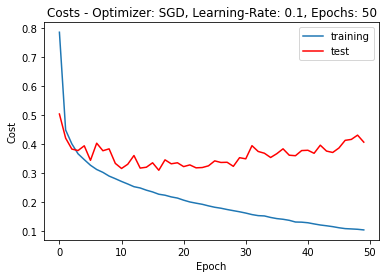

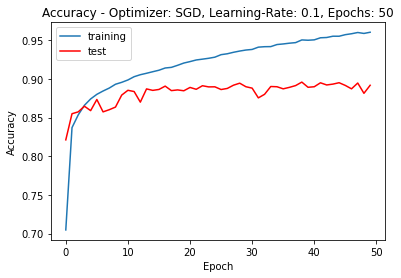

In [93]:
model = mlp()

nepochs = 50

lr = 0.1
mom = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=mom, nesterov=True)

experiment(model, optimizer, nepochs)

*Results* \
According to our results summarized in the table below, we can conclude the following takeaways: <br>

The best combination for the `SGD` optimizer, with momentum and (potentially) nesterov flag, is a number of epochs of `50`, with a learning rate of `0.1`, a momentum of `0.9` and the nesterov flag of `FALSE`. This results in a test accuracy of `0.893100`. This is only an imprivement of `0.0001` in comparison to plain SGD. The best train accuracy of `0.960380` is achieved with a number of epochs of `50`, with a learning rate of `0.1`, a momentum of `0.9`, with the nesterov flag of `TRUE`.

| Epochs | Learning Rate | Momentum | Nesterov | Train Costs | Train Accuracy | Test Costs | Test Accuracy |
|-------:|---------------|----------|----------|-------------|----------------|------------|---------------|
| 50     | 0.1           | 0.9      | FALSE    | 0.111388    | 0.957420       | 0.377825   | 0.893100      |
| 50     | 0.3           | 0.9      | FALSE    | 0.187607    | 0.929060       | 0.373821   | 0.888000      |
| 50     | 0.1           | 0.5      | FALSE    | 0.218863    | 0.918180       | 0.311848   | 0.892500      |
| 50     | 0.1           | 0.9      | TRUE     | 0.104527    | 0.960380       | 0.407541   | 0.891800      |

#### 3. RMSprop

*Exercise* \
Same thing now for RMSprop (without momentum). Play with different settings when using RMSprop: lr, alpha. Start with the default settings of pytorch with (lr=0.01, alpha=0.99,centered=False). Then vary alpha and independently the learning rate. Can you see an impact when using centered=True? What is your recommended best choice (learning rate, alpha, centered, nepochs) for the given problem?

*Link:* https://pytorch.org/docs/stable/generated/torch.optim.RMSprop.html

*With only Alpha*

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 4.852633 	 0.099620 		 5.441533 	 0.101300
1 		 4.218460 	 0.097580 		 6.072366 	 0.099400
2 		 4.196051 	 0.099940 		 6.512770 	 0.103000
3 		 4.259472 	 0.098060 		 5.288899 	 0.101100
4 		 4.229655 	 0.099920 		 4.908733 	 0.101400
5 		 4.203908 	 0.100820 		 4.425141 	 0.099900
6 		 4.203173 	 0.101960 		 5.346817 	 0.101400
7 		 4.221916 	 0.100120 		 3.413539 	 0.099300
8 		 4.189610 	 0.102280 		 7.203594 	 0.099300
9 		 4.229982 	 0.100520 		 7.184877 	 0.101400
10 		 4.263532 	 0.099240 		 5.914667 	 0.101300
11 		 4.188986 	 0.098160 		 5.656627 	 0.098000
12 		 4.209839 	 0.100540 		 6.276626 	 0.099900
13 		 4.228969 	 0.098240 		 3.740517 	 0.100100
14 		 4.241434 	 0.100220 		 8.348464 	 0.100100
15 		 4.195998 	 0.100180 		 3.662643 	 0.101100
16 		 4.202944 	 0.100640 		 4.819737 	 0.099400
17 		 4.256246 	 0.101360 		 4.466167 	 0.101100
18 		 4.211648 	 0.099460 		 4.799233 	 0.099300
19 		 4.1725

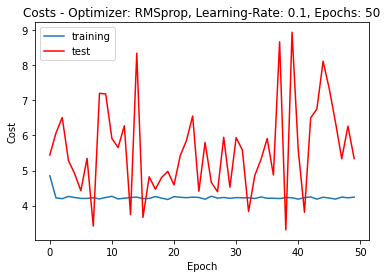

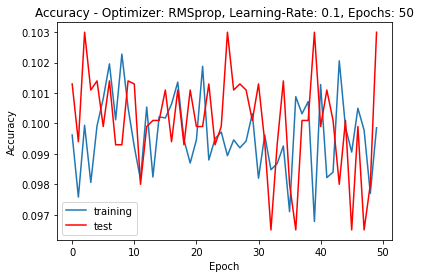

In [111]:
model = mlp()

nepochs = 50

lr = 0.1
alpha = 0.99
centered = False

optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=alpha, centered=centered)

experiment(model, optimizer, nepochs)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.266779 	 0.581160 		 1.155614 	 0.587900
1 		 1.110785 	 0.661580 		 0.963743 	 0.722900
2 		 1.118871 	 0.671100 		 1.351508 	 0.612300
3 		 1.139023 	 0.680460 		 1.107536 	 0.686300
4 		 1.095777 	 0.695080 		 1.439956 	 0.607600
5 		 1.155756 	 0.693940 		 1.166120 	 0.712700
6 		 1.181829 	 0.695280 		 2.091521 	 0.519200
7 		 1.192633 	 0.700940 		 1.568183 	 0.656200
8 		 1.211854 	 0.703460 		 1.246275 	 0.709300
9 		 1.185945 	 0.711400 		 1.340422 	 0.711200
10 		 1.110138 	 0.712580 		 1.340237 	 0.632400
11 		 1.129731 	 0.709980 		 2.184595 	 0.653200
12 		 1.193345 	 0.716660 		 0.974800 	 0.763200
13 		 1.187912 	 0.714040 		 1.018915 	 0.763900
14 		 1.225850 	 0.709460 		 1.336038 	 0.699400
15 		 1.235705 	 0.710980 		 1.667670 	 0.691300
16 		 1.243001 	 0.714320 		 1.321186 	 0.697600
17 		 1.308169 	 0.716580 		 1.511737 	 0.717600
18 		 1.339137 	 0.720040 		 1.235651 	 0.756300
19 		 1.3196

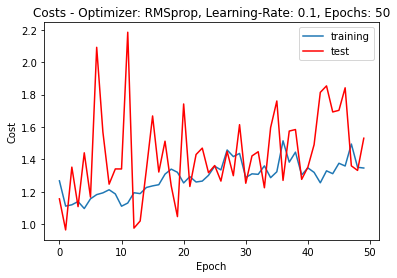

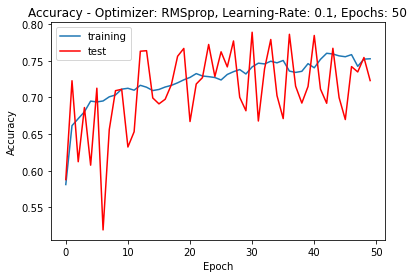

In [108]:
model = mlp()

nepochs = 50

lr = 0.1
alpha = 0.5
centered = False

optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=alpha, centered=centered)

experiment(model, optimizer, nepochs)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.294939 	 0.603300 		 1.665416 	 0.625700
1 		 1.293502 	 0.663080 		 1.585836 	 0.633400
2 		 1.316547 	 0.677280 		 1.731034 	 0.642900
3 		 1.359843 	 0.682480 		 1.236090 	 0.742500
4 		 1.297670 	 0.704520 		 2.566687 	 0.617500
5 		 1.295295 	 0.704300 		 1.605454 	 0.610200
6 		 1.363973 	 0.693800 		 1.393812 	 0.680700
7 		 1.290042 	 0.694580 		 1.448618 	 0.672200
8 		 1.394982 	 0.702580 		 1.462480 	 0.724400
9 		 1.614602 	 0.695680 		 1.245521 	 0.752500
10 		 1.566102 	 0.708340 		 1.208742 	 0.766700
11 		 1.499741 	 0.710600 		 1.363734 	 0.710700
12 		 1.407909 	 0.722320 		 1.425644 	 0.729700
13 		 1.520955 	 0.722260 		 1.507292 	 0.752700
14 		 1.470162 	 0.724120 		 1.398083 	 0.768600
15 		 1.482592 	 0.729620 		 1.725782 	 0.668400
16 		 1.532873 	 0.730340 		 1.663975 	 0.679300
17 		 1.491828 	 0.732220 		 2.344469 	 0.620000
18 		 1.581753 	 0.718340 		 2.061265 	 0.705600
19 		 1.4960

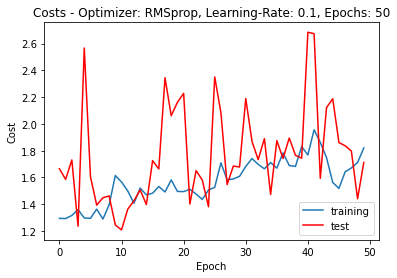

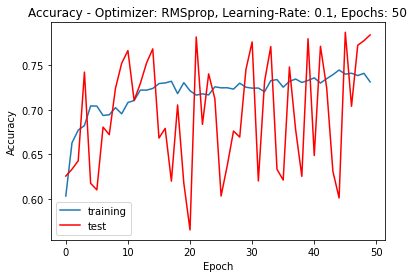

In [112]:
model = mlp()

nepochs = 50

lr = 0.1
alpha = 0.3
centered = False

optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=alpha, centered=centered)

experiment(model, optimizer, nepochs)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.426728 	 0.605500 		 1.837097 	 0.533700
1 		 1.510192 	 0.658240 		 1.376279 	 0.691900
2 		 1.560300 	 0.670960 		 1.569627 	 0.679800
3 		 1.559914 	 0.683500 		 1.555201 	 0.645100
4 		 1.490186 	 0.696240 		 1.891270 	 0.625200
5 		 1.488390 	 0.702940 		 1.180673 	 0.746100
6 		 1.593466 	 0.703280 		 2.907574 	 0.625000
7 		 1.588063 	 0.710280 		 1.802414 	 0.736200
8 		 1.548432 	 0.711340 		 2.198145 	 0.578400
9 		 1.531763 	 0.702800 		 1.776970 	 0.668000
10 		 1.513747 	 0.714980 		 1.541792 	 0.750200
11 		 1.502945 	 0.715820 		 1.478492 	 0.694200
12 		 1.483375 	 0.720860 		 1.434369 	 0.724200
13 		 1.536142 	 0.712660 		 1.648464 	 0.743100
14 		 1.574832 	 0.715640 		 1.891143 	 0.714400
15 		 1.522685 	 0.727000 		 1.360992 	 0.782200
16 		 1.515832 	 0.731560 		 1.185223 	 0.755600
17 		 1.469768 	 0.727780 		 1.224048 	 0.793800
18 		 1.614228 	 0.722680 		 1.569548 	 0.757300
19 		 1.6110

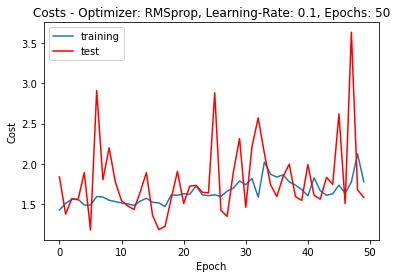

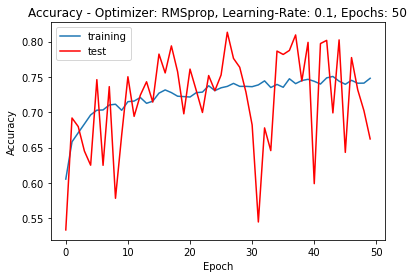

In [109]:
model = mlp()

nepochs = 50

lr = 0.1
alpha = 0.1
centered = False

optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=alpha, centered=centered)

experiment(model, optimizer, nepochs)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 4.522277 	 0.101120 		 7.037543 	 0.103000
1 		 3.956242 	 0.102960 		 3.633476 	 0.099900
2 		 3.924391 	 0.100840 		 6.215467 	 0.099300
3 		 3.977300 	 0.099000 		 3.488728 	 0.101100
4 		 3.936225 	 0.099440 		 3.744083 	 0.101300
5 		 3.960240 	 0.099780 		 5.308145 	 0.099900
6 		 3.939142 	 0.102560 		 4.917341 	 0.098000
7 		 3.941116 	 0.101640 		 5.094660 	 0.096500
8 		 3.943368 	 0.100880 		 4.428874 	 0.103000
9 		 3.932524 	 0.101080 		 4.584359 	 0.103000
10 		 3.968560 	 0.099620 		 2.957770 	 0.099400
11 		 3.956978 	 0.101540 		 7.074052 	 0.103000
12 		 3.943095 	 0.099760 		 4.137324 	 0.100100
13 		 3.971279 	 0.099340 		 5.455574 	 0.099400
14 		 3.950988 	 0.100320 		 4.207661 	 0.101400
15 		 3.955846 	 0.098800 		 4.878824 	 0.098000
16 		 3.936934 	 0.099260 		 5.127257 	 0.098000
17 		 3.950131 	 0.099120 		 3.571442 	 0.101300
18 		 3.972610 	 0.100960 		 5.257612 	 0.101400
19 		 3.9070

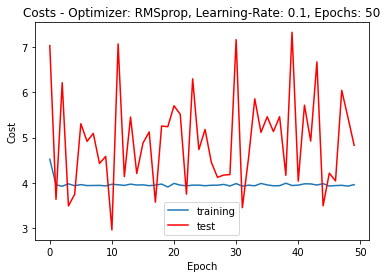

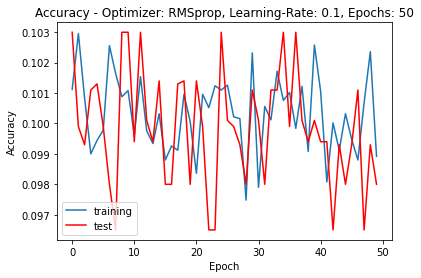

In [116]:
model = mlp()

nepochs = 50

lr = 0.1
alpha = 0.99
centered = True

optimizer = torch.optim.RMSprop(model.parameters(), lr=lr, alpha=alpha, centered=centered)

experiment(model, optimizer, nepochs)

*Results* \
According to our results summarized in the table below, we can conclude the following takeaways: <br>

The best combination for the `RMSprop` optimizer, with alpha and (potentially) centered flag, is a number of epochs of `50`, with a learning rate of `0.1`, an alpha of `0.3` and the centered flag of `FALSE`. This results in a test accuracy of `0.784300`. However, this is a decrease of `0.1088` in comparison to `SGD` with momentum. The best train accuracy of `0.752880` is achieved with a number of epochs of `50`, with a learning rate of `0.1`, an alpha of `0.5`, with the centered flag of `TRUE`. In general, `RMSprop` performed worse than `SGD`. Especially a high alpha value (default = `0.99`) leads to really poor results in train and test accuracy.

| Epochs | Learning Rate | Alpha | Centered | Train Costs | Train Accuracy | Test Costs | Test Accuracy |
|-------:|---------------|-------|----------|-------------|----------------|------------|---------------|
| 50     | 0.1           | 0.99  | FALSE    | 4.240498    | 0.099860       | 5.341797   | 0.103000      |
| 50     | 0.1           | 0.5   | FALSE    | 1.345997    | 0.752880       | 1.530108   | 0.723100      |
| 50     | 0.1           | 0.3   | FALSE    | 1.820362    | 0.731520       | 1.712053   | 0.784300      |
| 50     | 0.1           | 0.1   | FALSE    | 1.779828    | 0.748020       | 1.583616   | 0.662300      |
| 50     | 0.1           | 0.99  | TRUE     | 3.959916    | 0.098920       | 4.828771   | 0.098000      |

#### Adam

*Exercise* \
Same thing now for Adam. Play with different settings. Start with the default settings of pytorch. What is your recommended best choice for the given problem?

*Link:* https://pytorch.org/docs/stable/generated/torch.optim.Adam.html

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 2.498912 	 0.098940 		 2.548788 	 0.099400
1 		 2.488343 	 0.099440 		 2.378713 	 0.099400
2 		 2.491339 	 0.099540 		 2.462513 	 0.098000
3 		 2.501667 	 0.099780 		 2.502675 	 0.099400
4 		 2.481439 	 0.100920 		 2.481264 	 0.098000
5 		 2.486886 	 0.098940 		 2.407359 	 0.099300
6 		 2.478725 	 0.099680 		 2.601007 	 0.101300
7 		 2.508662 	 0.098300 		 2.510501 	 0.099300
8 		 2.489117 	 0.099120 		 2.590594 	 0.101100
9 		 2.490254 	 0.099080 		 2.499093 	 0.103000
10 		 2.499546 	 0.100100 		 2.406952 	 0.100100
11 		 2.503388 	 0.100280 		 2.566822 	 0.096500
12 		 2.492423 	 0.102880 		 2.399153 	 0.099400
13 		 2.486463 	 0.100580 		 2.557740 	 0.101400
14 		 2.476208 	 0.100340 		 2.519002 	 0.101100
15 		 2.505184 	 0.100860 		 2.481390 	 0.099300
16 		 2.487544 	 0.099800 		 2.496600 	 0.101100
17 		 2.495435 	 0.100640 		 2.429002 	 0.099300
18 		 2.504169 	 0.098760 		 2.341202 	 0.100100
19 		 2.4865

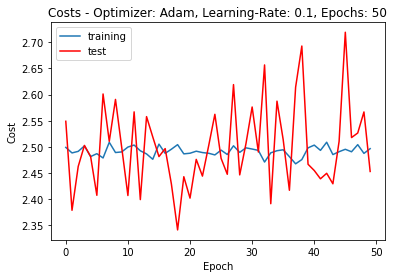

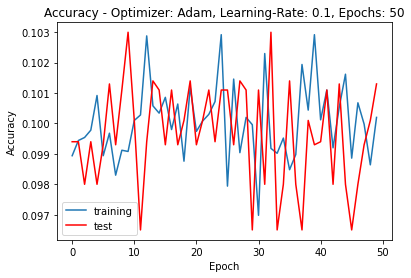

In [117]:
model = mlp()

nepochs = 50

lr = 0.1

optimizer = torch.optim.Adam(model.parameters(), lr=lr)

experiment(model, optimizer, nepochs)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.798369 	 0.363780 		 1.137201 	 0.685100
1 		 1.230784 	 0.620460 		 1.663716 	 0.634900
2 		 1.230902 	 0.626760 		 1.086785 	 0.713800
3 		 1.206001 	 0.639780 		 1.570298 	 0.536600
4 		 1.181000 	 0.652540 		 1.086433 	 0.616800
5 		 1.220520 	 0.649480 		 1.942976 	 0.440700
6 		 1.296131 	 0.642480 		 1.393370 	 0.692400
7 		 1.178407 	 0.663640 		 1.579416 	 0.537400
8 		 1.180311 	 0.663860 		 1.345597 	 0.633000
9 		 1.234200 	 0.653120 		 1.811281 	 0.523200
10 		 1.368209 	 0.641320 		 1.079773 	 0.718300
11 		 1.273443 	 0.653080 		 1.587553 	 0.607800
12 		 1.254509 	 0.667020 		 1.550313 	 0.671200
13 		 1.309550 	 0.666580 		 1.517410 	 0.729300
14 		 1.338484 	 0.662340 		 1.317161 	 0.713500
15 		 1.405101 	 0.662380 		 1.770910 	 0.665300
16 		 1.391345 	 0.665860 		 1.686025 	 0.533600
17 		 1.334423 	 0.666480 		 1.581418 	 0.588100
18 		 1.322004 	 0.674320 		 1.310128 	 0.656000
19 		 1.3323

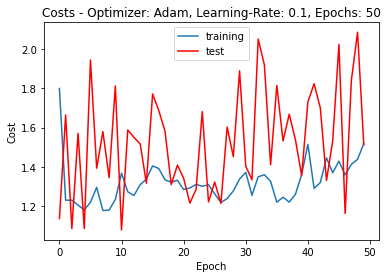

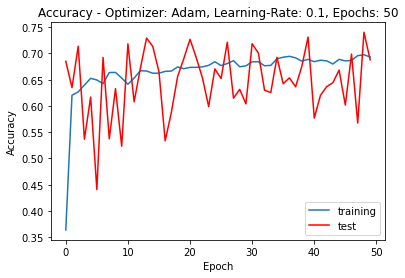

In [118]:
model = mlp()

nepochs = 50

lr = 0.1
betas = [0.5, 0.5]

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

experiment(model, optimizer, nepochs)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.316799 	 0.581160 		 1.282163 	 0.695100
1 		 1.277361 	 0.666500 		 1.975383 	 0.631500
2 		 1.406030 	 0.677440 		 1.334343 	 0.648100
3 		 1.457255 	 0.674920 		 1.549578 	 0.708000
4 		 1.513711 	 0.673620 		 1.567144 	 0.647000
5 		 1.491626 	 0.693720 		 1.573151 	 0.671000
6 		 1.438239 	 0.693720 		 1.525575 	 0.695100
7 		 1.505220 	 0.697180 		 1.474379 	 0.677200
8 		 1.650483 	 0.699140 		 2.230435 	 0.693000
9 		 1.682962 	 0.700120 		 1.500318 	 0.742600
10 		 1.512474 	 0.707680 		 1.482104 	 0.741800
11 		 1.531649 	 0.711180 		 1.464552 	 0.709800
12 		 1.665038 	 0.711180 		 1.831714 	 0.604100
13 		 1.764703 	 0.700800 		 2.203728 	 0.724200
14 		 1.972224 	 0.689640 		 2.363783 	 0.740400
15 		 2.084468 	 0.691140 		 2.251926 	 0.606100
16 		 1.843520 	 0.697500 		 3.129870 	 0.596500
17 		 2.009300 	 0.704240 		 1.951036 	 0.626900
18 		 1.724211 	 0.712560 		 1.742305 	 0.645900
19 		 1.9433

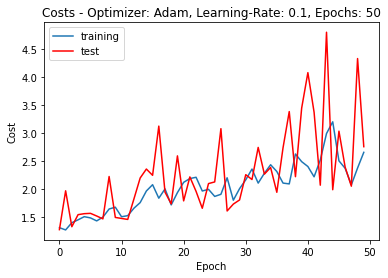

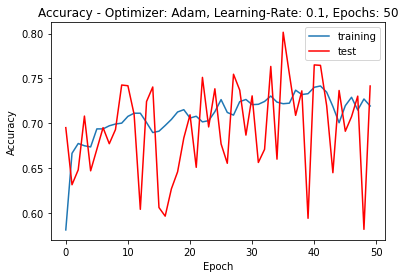

In [119]:
model = mlp()

nepochs = 50

lr = 0.1
betas = [0.1, 0.1]

optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=betas)

experiment(model, optimizer, nepochs)

*Results* \
According to our results summarized in the table below, we can conclude the following takeaways: <br>

The best combination for the `Adam` optimizer, with betas, is a number of epochs of `50`, with a learning rate of `0.1` and betas of `[0.1, 0.1]`. This results in a test accuracy of `0.741500`. However, this is a decrease of `0.1515` in comparison to `SGD` with momentum. The best train accuracy of `0.719260` is achieved with the same combination of hyperparameters. In general, `Adam` performed worse than `SGD`. Especially high beta values (default = `[0.9, 0.999]`) leads to really poor results in train and test accuracy.

| Epochs | Learning Rate | Betas        | Train Costs | Train Accuracy | Test Costs | Test Accuracy |
|-------:|---------------|--------------|-------------|----------------|------------|---------------|
| 50     | 0.1           | [0.9, 0.999] | 2.496486    | 0.100200       | 2.452930   | 0.101300      |
| 50     | 0.1           | [0.5, 0.5]   | 1.518825    | 0.693200       | 1.512029   | 0.687800      |
| 50     | 0.1           | [0.1, 0.1]   | 2.661779    | 0.719260       | 2.762799   | 0.741500      |


In [14]:
0.893000- 0.741500

0.15149999999999997

#### Learning Rate Schedule

*Exercise* \
Learning rate schedule: Implement a learning rate schedule for SGD (without momentum) - by using e.g. StepLR. What are your preferred settings for the given task? Note the way how the scheduler is incorporated into the train_eval-method above.

*Link:* https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.StepLR.html

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.729726 	 0.372520 		 1.096251 	 0.576600
1 		 0.929084 	 0.653360 		 0.790419 	 0.699600
2 		 0.704554 	 0.740020 		 0.633377 	 0.770800
3 		 0.607005 	 0.773520 		 0.573624 	 0.777700
4 		 0.555568 	 0.798920 		 0.533400 	 0.808600
5 		 0.525364 	 0.813580 		 0.515107 	 0.820300
6 		 0.521885 	 0.815420 		 0.512534 	 0.821100
7 		 0.518243 	 0.817380 		 0.507277 	 0.820800
8 		 0.514775 	 0.817720 		 0.505090 	 0.822400
9 		 0.511520 	 0.819580 		 0.502745 	 0.822000
10 		 0.509142 	 0.819700 		 0.500067 	 0.823700
11 		 0.508688 	 0.820060 		 0.500213 	 0.823900
12 		 0.508770 	 0.820360 		 0.500796 	 0.824100
13 		 0.508205 	 0.820300 		 0.501157 	 0.824200
14 		 0.508071 	 0.820520 		 0.501492 	 0.824500
15 		 0.508166 	 0.820220 		 0.499636 	 0.824700
16 		 0.507613 	 0.820260 		 0.499423 	 0.824500
17 		 0.507450 	 0.820380 		 0.500076 	 0.824900
18 		 0.507336 	 0.820460 		 0.499101 	 0.824600
19 		 0.5080

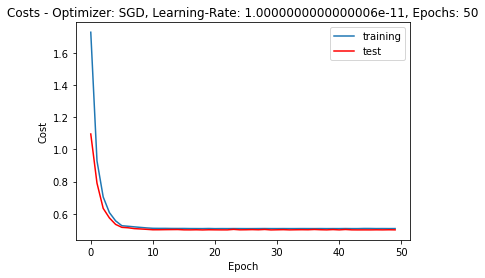

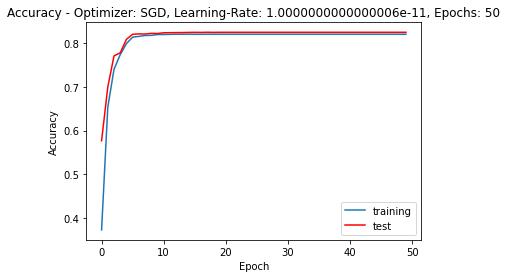

In [103]:
model = mlp()

nepochs = 50

lr = 0.1

step_size = 5

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size)
                   
experiment(model, optimizer, nepochs, scheduler=scheduler)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.771694 	 0.364660 		 1.102068 	 0.598700
1 		 0.927948 	 0.658980 		 0.783564 	 0.726200
2 		 0.711012 	 0.739620 		 0.645444 	 0.758300
3 		 0.615622 	 0.770660 		 0.577567 	 0.789900
4 		 0.561944 	 0.793120 		 0.553800 	 0.793400
5 		 0.526680 	 0.809960 		 0.582187 	 0.785000
6 		 0.500417 	 0.821120 		 0.495519 	 0.825800
7 		 0.479004 	 0.827080 		 0.501591 	 0.817300
8 		 0.460770 	 0.834720 		 0.460572 	 0.837300
9 		 0.446528 	 0.839440 		 0.462535 	 0.832100
10 		 0.428212 	 0.846780 		 0.426056 	 0.850200
11 		 0.425890 	 0.847760 		 0.425342 	 0.850900
12 		 0.424678 	 0.847780 		 0.425808 	 0.851300
13 		 0.423560 	 0.848500 		 0.425632 	 0.850900
14 		 0.422015 	 0.849800 		 0.424147 	 0.851700
15 		 0.420965 	 0.850060 		 0.425918 	 0.848900
16 		 0.419753 	 0.849660 		 0.421434 	 0.851700
17 		 0.418622 	 0.850160 		 0.422421 	 0.851500
18 		 0.417541 	 0.851000 		 0.418323 	 0.854600
19 		 0.4162

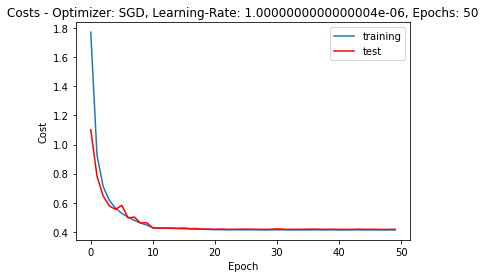

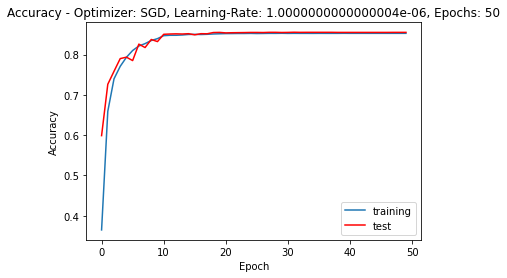

In [104]:
model = mlp()

nepochs = 50

lr = 0.1

step_size = 10

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size)
                   
experiment(model, optimizer, nepochs, scheduler=scheduler)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.730309 	 0.380620 		 1.074036 	 0.623000
1 		 0.895207 	 0.665740 		 0.764672 	 0.712700
2 		 0.685925 	 0.745620 		 0.644343 	 0.750800
3 		 0.598717 	 0.778020 		 0.563480 	 0.796500
4 		 0.552105 	 0.801120 		 0.556820 	 0.789600
5 		 0.521701 	 0.814000 		 0.537375 	 0.806800
6 		 0.497176 	 0.822860 		 0.514354 	 0.817200
7 		 0.478494 	 0.829200 		 0.509110 	 0.809300
8 		 0.463126 	 0.834280 		 0.450771 	 0.840500
9 		 0.449745 	 0.840280 		 0.466984 	 0.832800
10 		 0.438461 	 0.842740 		 0.433178 	 0.850500
11 		 0.428542 	 0.845980 		 0.422187 	 0.853100
12 		 0.419423 	 0.848180 		 0.421994 	 0.850800
13 		 0.412094 	 0.851900 		 0.421653 	 0.848600
14 		 0.403545 	 0.855240 		 0.412916 	 0.854000
15 		 0.398407 	 0.856720 		 0.401615 	 0.858900
16 		 0.391726 	 0.857860 		 0.411082 	 0.856600
17 		 0.386205 	 0.859920 		 0.404809 	 0.856700
18 		 0.379770 	 0.863400 		 0.407400 	 0.850400
19 		 0.3762

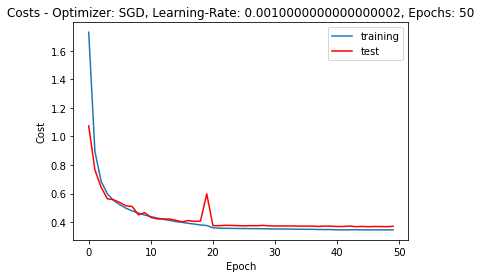

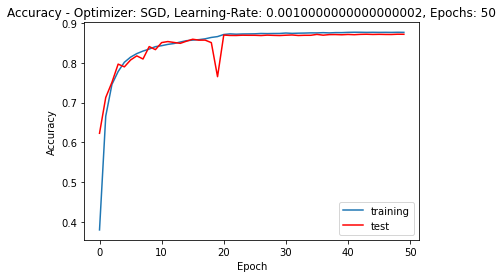

In [105]:
model = mlp()

nepochs = 50

lr = 0.1

step_size = 20

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size)
                   
experiment(model, optimizer, nepochs, scheduler=scheduler)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.167147 	 0.555880 		 0.778352 	 0.702000
1 		 0.602558 	 0.775600 		 0.607962 	 0.767100
2 		 0.514713 	 0.814220 		 0.612863 	 0.761200
3 		 0.470765 	 0.830620 		 0.467892 	 0.834000
4 		 0.439050 	 0.841060 		 0.557761 	 0.786200
5 		 0.418493 	 0.847340 		 0.419482 	 0.846900
6 		 0.401278 	 0.854380 		 0.445146 	 0.841600
7 		 0.387285 	 0.859400 		 0.412737 	 0.848400
8 		 0.372958 	 0.864660 		 0.465545 	 0.838200
9 		 0.364326 	 0.866360 		 0.492333 	 0.821500
10 		 0.355678 	 0.869780 		 1.059844 	 0.670300
11 		 0.346606 	 0.873180 		 0.379801 	 0.859300
12 		 0.337028 	 0.875920 		 0.411365 	 0.846500
13 		 0.328965 	 0.879600 		 0.389181 	 0.861100
14 		 0.323182 	 0.880900 		 0.419037 	 0.840700
15 		 0.316576 	 0.883720 		 0.404105 	 0.849600
16 		 0.310549 	 0.886020 		 0.375428 	 0.868800
17 		 0.305298 	 0.887800 		 0.397910 	 0.855500
18 		 0.298825 	 0.889460 		 0.329023 	 0.880700
19 		 0.2934

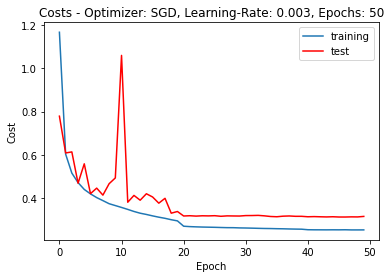

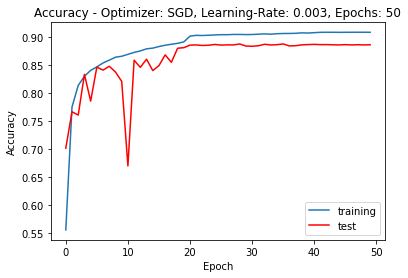

In [106]:
model = mlp()

nepochs = 50

lr = 0.3

step_size = 20

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size)
                   
experiment(model, optimizer, nepochs, scheduler=scheduler)

Epoch 		 Train Costs 	 Train Accuracy 	 Test Costs 	 Test Accuracy
0 		 1.003897 	 0.612400 		 0.916097 	 0.687400
1 		 0.552028 	 0.796860 		 0.623805 	 0.761500
2 		 0.474954 	 0.828000 		 0.972823 	 0.661000
3 		 0.436357 	 0.840900 		 0.443231 	 0.840600
4 		 0.407019 	 0.850520 		 0.463158 	 0.833600
5 		 0.385601 	 0.858000 		 0.404726 	 0.858000
6 		 0.370794 	 0.864020 		 0.414711 	 0.842400
7 		 0.355386 	 0.869760 		 0.412903 	 0.850300
8 		 0.345033 	 0.871480 		 0.423207 	 0.848200
9 		 0.336464 	 0.874820 		 0.349026 	 0.875300
10 		 0.304779 	 0.888620 		 0.343673 	 0.877700
11 		 0.300419 	 0.890000 		 0.334379 	 0.880700
12 		 0.297224 	 0.890120 		 0.333566 	 0.881500
13 		 0.294634 	 0.891920 		 0.341582 	 0.876300
14 		 0.291377 	 0.893020 		 0.331362 	 0.881100
15 		 0.288219 	 0.893840 		 0.345339 	 0.877000
16 		 0.286400 	 0.894200 		 0.331630 	 0.882200
17 		 0.283357 	 0.895940 		 0.327429 	 0.881100
18 		 0.280993 	 0.896820 		 0.321627 	 0.886500
19 		 0.2785

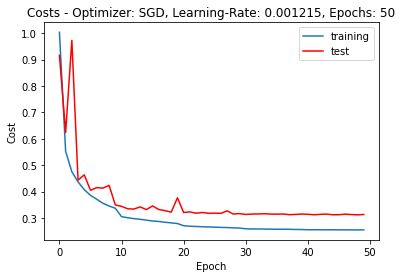

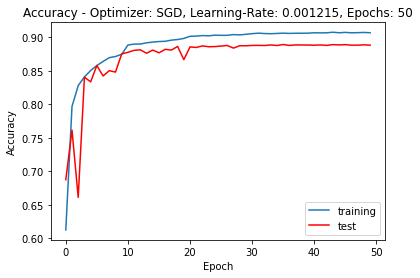

In [17]:
model = mlp()

nepochs = 50

lr = 0.5


step_size = 10
gamma = 0.3

optimizer = torch.optim.SGD(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
                   
experiment(model, optimizer, nepochs, scheduler=scheduler)

*Results* \
According to our results summarized in the table below, we can conclude the following takeaways: <br>

The best combination for the `SGD` optimizer with a `StepLR`, is a number of epochs of `50`, with a learning rate of `0.5`, a step size of `10` and a gamma of `0.3`. This results in a test accuracy of `0.888400`. However, this is a slight decrease of `0.0047` in comparison to `SGD` with just momentum. The best train accuracy of `0.909200` is achieved with a number of epochs of `50`, with a learning rate of `0.3`, a step size of `30`, and a gamma of `0.1`. In general, `RMSprop` similar to plain `SGD` (no surpises here). However, we did not find a combination of hyperparameters which improved the plain `SGD` optimizer without a `StepLR`.

| Epochs | Learning Rate | Step Size | Gamma | Train Costs | Train Accuracy | Test Costs | Test Accuracy |
|-------:|---------------|-----------|-------|-------------|----------------|------------|---------------|
| 50     | 0.1           | 5         | 0.1   | 0.507519    | 0.820360       | 0.499544   | 0.824800      |
| 50     | 0.1           | 10        | 0.1   | 0.413039    | 0.852600       | 0.416992   | 0.855000      |
| 50     | 0.1           | 20        | 0.1   | 0.345224    | 0.876140       | 0.370817   | 0.871300      |
| 50     | 0.3           | 20        | 0.1   | 0.251667    | 0.909200       | 0.314098   | 0.886900      |
| 50     | 0.5           | 10        | 0.3   | 0.254462    | 0.906960       | 0.312714   | 0.888400      |